In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import scipy.io.wavfile as wav

Processing songs: 0it [00:00, ?it/s]

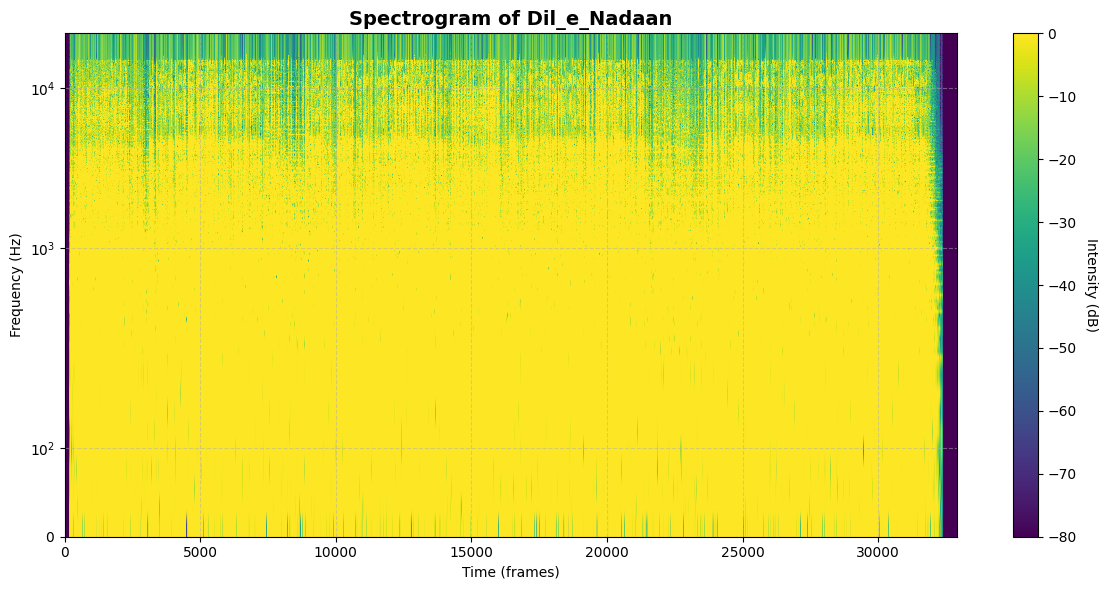

Processing songs: 1it [00:08,  8.64s/it]

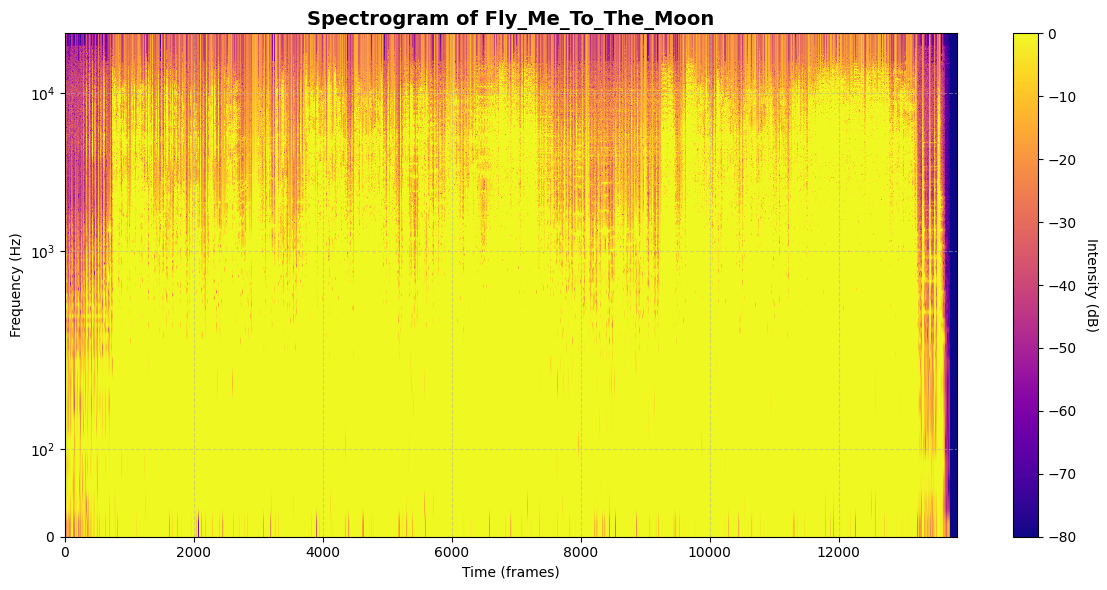

Processing songs: 2it [00:11,  5.40s/it]

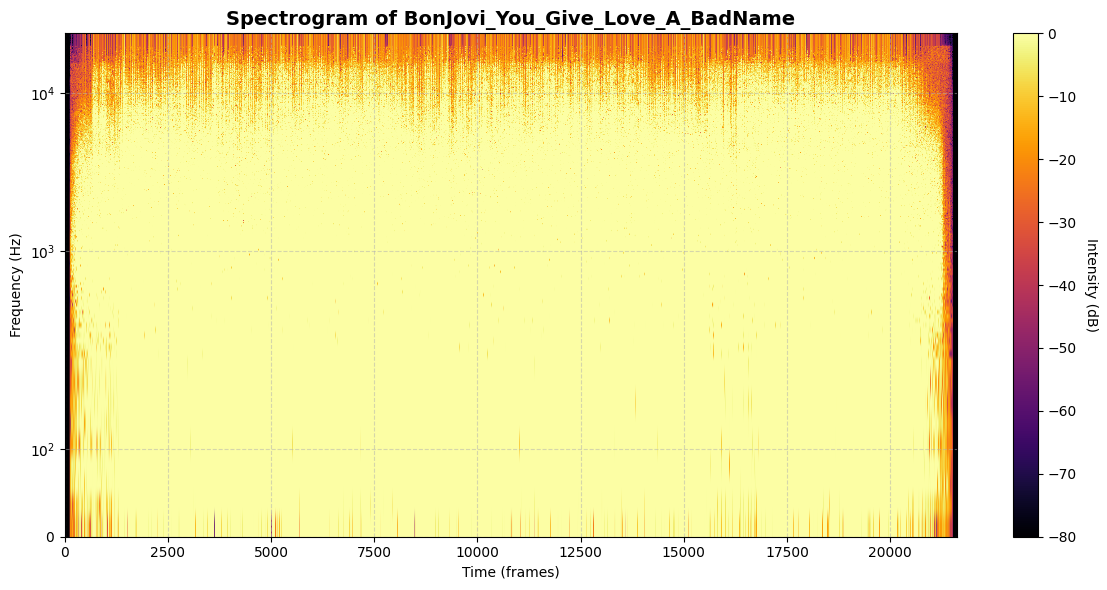

Processing songs: 3it [00:16,  5.06s/it]

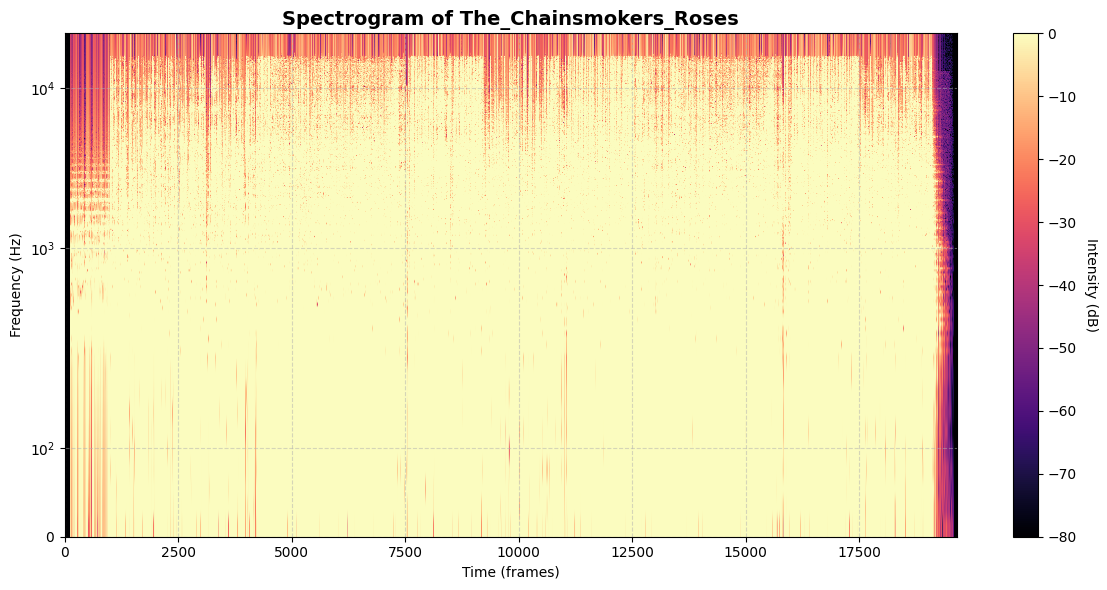

Processing songs: 4it [00:21,  5.37s/it]



Cosine Similarity Matrix among all spectrograms:
                          Dil_e_Nadaan              Fly_Me_To_The_Moon        BonJovi_You_Give_Love_A_BadName The_Chainsmokers_Roses   
Dil_e_Nadaan                                 1.0018                    0.7652                    0.7719                    0.7813
Fly_Me_To_The_Moon                           0.7665                    1.0001                    0.7233                    0.7150
BonJovi_You_Give_Love_A_BadName                    0.7737                    0.7236                    1.0011                    0.8475
The_Chainsmokers_Roses                       0.7844                    0.7160                    0.8484                    1.0012


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from tqdm import tqdm

def compute_spectrogram(waveform, sample_rate, n_fft=2048, hop_length=512):
    
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    magnitude = torch.abs(stft)
    return 20 * torch.log10(magnitude + 1e-8)

def load_and_compute_spectrogram(file_path):
    
    sample_rate, waveform = wav.read(file_path)

    # If stereo, convert to mono by taking mean of channels
    if len(waveform.shape) > 1:
        waveform = waveform.mean(axis=1)

    
    waveform = waveform / np.max(np.abs(waveform))

   
    waveform = torch.from_numpy(waveform).float()

    # Compute spectrogram
    spec = compute_spectrogram(waveform, sample_rate)
    return spec, sample_rate

def plot_spectrogram(spectrogram, title, color, sample_rate):
    
    plt.figure(figsize=(12, 6))

  
    plt.imshow(
        spectrogram.numpy(),
        aspect='auto',
        origin='lower',
        cmap=color,
        extent=[0, spectrogram.shape[1], 0, sample_rate // 2],
        vmin=-80,
        vmax=0
    )

  
    plt.grid(True, linestyle='--', alpha=0.5)
    cbar = plt.colorbar()
    cbar.set_label('Intensity (dB)', rotation=270, labelpad=15)

    #use a symmetric log scale for the y-axis to better see lower frequencies
    plt.yscale('symlog', linthresh=200)

    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Spectrogram of {title}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def spectrogram_similarity(spec1: torch.Tensor, spec2: torch.Tensor) -> float:
    spec1 = spec1.float()
    spec2 = spec2.float()

   
    if spec1.shape != spec2.shape:
        spec1 = spec1.unsqueeze(0).unsqueeze(0)  # shape: (1,1,freq,time)
        target_shape = (spec2.shape[0], spec2.shape[1])
        spec1 = F.interpolate(spec1, size=target_shape, mode='bilinear', align_corners=False)
        spec1 = spec1.squeeze(0).squeeze(0)

    
    spec1_flat = spec1.flatten()
    spec2_flat = spec2.flatten()

    
    cos_sim = F.cosine_similarity(spec1_flat, spec2_flat, dim=0)
    return cos_sim.item()


if __name__ == "__main__":
    file_paths = [
        "/content/Dil_e_Nadaan.wav",
        "/content/Fly_Me_To_The_Moon.wav",
        "/content/BonJovi_You_Give_Love_A_BadName.wav",
        "/content/The_Chainsmokers_Roses.wav"
    ]

    titles = [
        "Dil_e_Nadaan",
        "Fly_Me_To_The_Moon",
        "BonJovi_You_Give_Love_A_BadName",
        "The_Chainsmokers_Roses"
    ]

    genre_colors = ["viridis", "plasma", "inferno", "magma"]

    spectrograms = []
    sample_rates = []

  
    for file_path, title, color in tqdm(zip(file_paths, titles, genre_colors), desc="Processing songs"):
        spec, sr = load_and_compute_spectrogram(file_path)
        spectrograms.append(spec)
        sample_rates.append(sr)
        plot_spectrogram(spec, title, color, sr)

    #---Compute the Cosine Similarity Matrix among all spectrograms ---
    n_songs = len(spectrograms)
    similarity_matrix = np.zeros((n_songs, n_songs), dtype=float)

    for i in range(n_songs):
        for j in range(n_songs):
            similarity_matrix[i, j] = spectrogram_similarity(spectrograms[i], spectrograms[j])

    #Print the similarity matrix with song titles
    print("\nCosine Similarity Matrix among all spectrograms:")
    
    print(f"{'':25} " + " ".join(f"{t:25}" for t in titles))


    for i, song_i in enumerate(titles):
        row_values = " ".join(f"{similarity_matrix[i, j]:25.4f}" for j in range(n_songs))
        print(f"{song_i:25} {row_values}")
